In [1]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def textwidth_to_inch(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    return fig_width_pt*inches_per_pt*scale         # width in inches

def figsize(scale):
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = textwidth_to_inch(scale)
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import glob
import os

from math import log

import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams.update(pgf_with_latex)

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/lp_scaling/*.json")) + glob.glob(os.path.expanduser("~/dev/ma/data/results/dlm_scaling/*.json")) + glob.glob(os.path.expanduser("~/dev/ma/data/results/plm_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
frames['program_run']['worker_label'] = frames['program_run']['hosts'].map(str) + 'x' + frames['program_run']['workers_per_host'].map(str)

In [4]:
progs = {
    '/home/kit/iti/kp0036/code/prototypes/thrill_louvain/release/node_based_local_moving': 'DLSLM',
    '/home/kit/iti/kp0036/code/prototypes/thrill_louvain/release/label_prop': 'LP',
    '/home/kit/iti/kp0036/code/prototypes/thrill_louvain/release/partitioned_louvain': 'DLPLM'
}

frames['program_run'].replace({ 'binary': progs }, inplace=True)

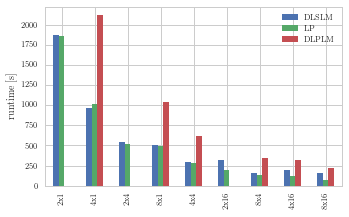

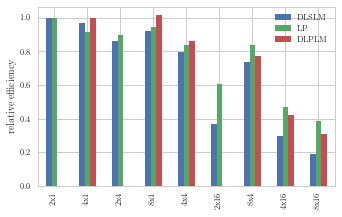

In [11]:
runtimes = pd.DataFrame()
efficiencies = pd.DataFrame()

for i, algo in [(0, 'DLSLM'), (1, 'LP'), (2, 'DLPLM')]:
    label = algo
    if algo == 'LP':
        plot_data = frames['program_run'] \
            .loc[lambda x: x.binary == algo] \
            .loc[lambda x: x.node_count == 10000000] \
            .loc[lambda x: x.workers_per_host != 27] \
            .sort_values(by='total_workers') \
            .set_index('worker_label')
    else:
        plot_data = frames['algorithm_run'] \
            .merge(frames['program_run'].drop('runtime', 1), left_on='program_run_id', right_index=True, how='right') \
            .loc[lambda x: x.binary == algo] \
            .loc[lambda x: x.node_count == 10000000] \
            .loc[lambda x: x.workers_per_host != 27] \
            .groupby('worker_label')[['runtime', 'total_workers']].mean() \
            .sort_values(by='total_workers')
        
    plot_data['speedup'] = plot_data['runtime'].dropna().iloc[0] / plot_data['runtime']
    plot_data['efficiency'] = plot_data['total_workers'].dropna().iloc[0] * plot_data['speedup'] / plot_data['total_workers']
    
    runtimes[algo] = plot_data['runtime']
    efficiencies[algo] = plot_data['efficiency']

ax = runtimes.plot.bar()
ax.set_xlabel('')
ax.set_ylabel('runtime [s]')
savefig('pres_scaling_runtime')

ax = efficiencies.plot.bar()
ax.set_xlabel('')
ax.set_ylabel('relative efficiency')
savefig('pres_scaling_eff')